In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 

In [3]:
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Select range of events
nmin=0
nmax=5000

#Select quality 0 Z->mumu
Zmumu_pt=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin:nmax]
Zmumu_eta=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin:nmax]
Zmumu_phi=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin:nmax]

#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]

quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


100%|██████████| 5000/5000 [00:04<00:00, 1202.74it/s]


energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


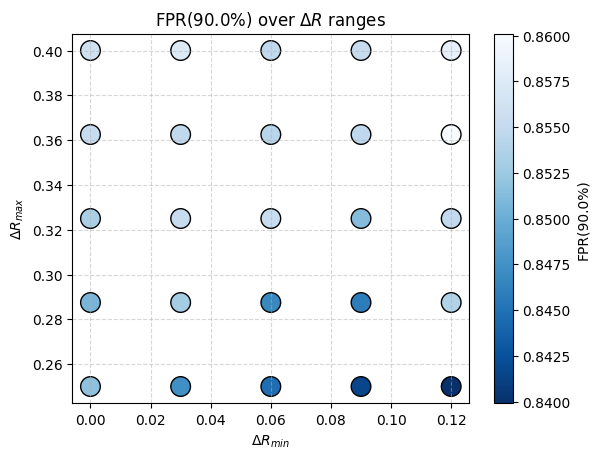

(array([[0.85170732, 0.85066458, 0.85330714, 0.85514541, 0.85609398],
        [0.84737364, 0.8528481 , 0.85525446, 0.85472973, 0.85735366],
        [0.8447205 , 0.84678077, 0.85530764, 0.85411899, 0.85465406],
        [0.84151786, 0.84582257, 0.85130374, 0.85462036, 0.8551093 ],
        [0.83990148, 0.85372585, 0.85482682, 0.86009732, 0.8584117 ]]),
 array([0.  , 0.03, 0.06, 0.09, 0.12]),
 array([0.25  , 0.2875, 0.325 , 0.3625, 0.4   ]))

In [16]:
ROC_FPR_2D_plot(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                 ZeroBias_phi, steps=5, dr_max_range=[0.25,0.4], dr_min_range=[0,0.12])

In [11]:
ROC_FPR_efficiency(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt,
                    ZeroBias_eta, ZeroBias_phi, dr_min=0.2, dr_max=0.32) 

(np.float64(0.8478931140801644), 0.2, 0.32)

Computing ROC curve:  20%|██        | 1/5 [00:21<01:27, 21.93s/it]/home/ruben/anaconda3/envs/thesis/lib/python3.13/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


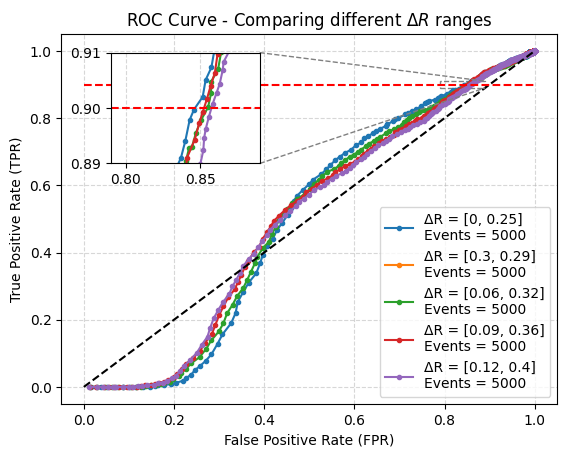

[[<Array [0.0166, 0.0371, 0.0517, 0.0693, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [nan, nan, nan, nan, nan, ..., nan, nan, nan, nan] type='999 * float64'>,
  <Array [nan, nan, nan, nan, nan, ..., nan, nan, nan, nan] type='999 * float64'>],
 [<Array [0.0128, 0.0297, 0.0467, 0.0629, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.0129, 0.0271, 0.0447, 0.0565, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>],
 [<Array [0.0115, 0.0282, 0.0428, 0.0528, ..., 1, 1, 1, 1] type='999 * float64'>,
  <Array [0, 0, 0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1, 1, 1] type='999 * float64'>]]

In [4]:
plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta, ZeroBias_phi,
                [0, 5000],[0,5000], np.linspace(0,1,1000), dr_min=[0, 0.3, 0.06, 0.09, 0.12], dr_max=[0.25, 0.2875, 0.325, 0.3625, 0.4])

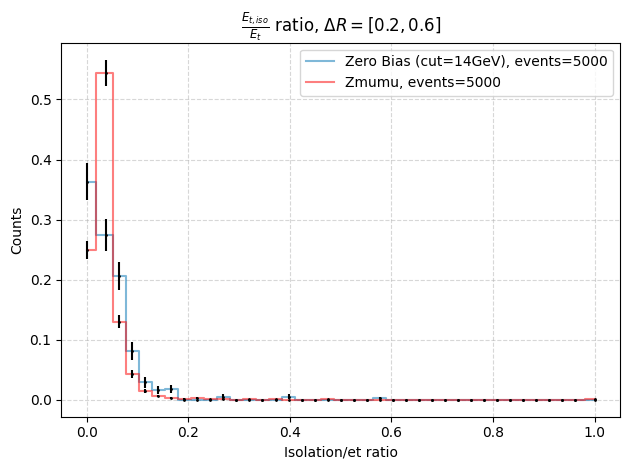

In [ ]:
dr_min=0.2
dr_max=0.25
#Compute the isolation and prepare it for plotting ZeroBias
res1=muon_isolation_all_events(MuonTree_ZeroBias,ZeroBias_eta,ZeroBias_phi,dr_min,dr_max,[nmin,nmax],1000)
data1=ak.flatten(res1)
#Prepare the data
ratio1=data1/ak.flatten(ZeroBias_pt)

#Compute the isolation and prepare it for plotting Z mu mu
res2=muon_isolation_all_events(MuonTree_Zmumu,Zmumu_eta,Zmumu_phi,dr_min,dr_max,[nmin,nmax],1000)
data2=ak.flatten(res2)

ratio2=data2/ak.flatten(Zmumu_pt)

#Plot the data
colors=["#0072B2", "#FD0000"]
labels=[fr"Zero Bias (cut=14GeV), events={len(res1)}", fr"Zmumu, events={len(res2)}"]

coolplot([ratio1,ratio2],np.linspace(0,1,40),colors,labels, "Isolation/et ratio","Counts",
         r"$\frac{E_{t,iso}}{E_{t}}$ ratio, $\Delta R= [0.2,0.6]$")